In [11]:
import os,glob
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import aacgmv2
import spacepy.coordinates as coord
import spacepy
import matplotlib
import igrf
# matplotlib.use("tkagg")
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy.spatial import Delaunay
from scipy.stats import pearsonr
from tqdm import tqdm
from spacepy.time import Ticktock
import auromat
from auromat.coordinates.transform import geodetic2Ecef, geoToMLatMLT, geodetic2EcefZero,mltToSmLon
from mpl_toolkits.basemap import Basemap
import mpl_axes_aligner
%matplotlib widget
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [26]:
def geotomag(t,lon,lat,alt): ## uses spacepy
    #call with altitude in kilometers and lat/lon in degrees 
    Re=6371.0 #mean Earth radius in kilometers
    #setup the geographic coordinate object with altitude in earth radii 
    cvals = coord.Coords([float(alt+Re)/Re, float(lat), float(lon)], 'GEO', 'sph',['Re','deg','deg'],use_irbem=True)
    #set time epoch for coordinates:
    cvals.ticks=Ticktock([t.strftime('%Y-%m-%dT%H:%M:%S')], 'ISO')
    #return the magnetic coords in the same units as the geographic:
    return cvals.convert('MAG','sph').data[0]

def geo2mlatmlt(t,lon,lat,alt): ## uses auromat package 
    #call with altitude in kilometers and lat/lon in degrees
    lon = np.deg2rad(lon);
    lat = np.deg2rad(lat);
    XYZ = geodetic2Ecef(lat, lon, alt, a=6378.137, b=6356.752314245179)
    XYZ = np.array(XYZ).reshape(1,3)
    mlat,mlt = geoToMLatMLT(XYZ,t)
    mlon = mltToSmLon(mlt, out=None)
    return float(mlat),float(mlt)

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def find_orbits(df):
    gaps = np.where(np.array([(df.index[m+1]-df.index[m])/dt.timedelta(seconds=1) for m in range(len(df)-1)])>500)[0]
    gaps = np.insert(gaps,[0,len(gaps)],[0,len(df)-1])
    orbit_end = df.index[gaps]
    return orbit_end
def running_correlation(arr1, arr2, window_size):
    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must have the same length")

    n = len(arr1)
    correlations = np.zeros(n)

    for i in range(n):
        if (i < int(window_size/2) - 1) or (i > n - int(window_size/2) + 1) :
            # Not enough data points to compute correlation
            correlations[i] = np.nan
        else:
            # Calculate the correlation for the current window
            window1 = arr1[i - int(window_size/2) + 1 : i + 1 + int(window_size/2)]
            window2 = arr2[i - int(window_size/2) + 1 : i + 1 + int(window_size/2)]
            corr, _ = pearsonr(window1, window2)
            correlations[i] = corr

    return correlations

In [27]:
start = dt.datetime(2013,1,7,0,0,0); stop = dt.datetime(2013,1,13,0,0,0); 
sat = 'GOCE';
days=int((stop-start)/dt.timedelta(days=1));

In [28]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\EPB stuff\\Data\\OMNI Data\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/EPB stuff/Data/OMNI Data/';
os.chdir(filepath)
filename = 'omni2_hourly_indices.txt';
SW_Data_hr = pd.DataFrame(np.loadtxt(filename,dtype = float));
time_array = [dt.datetime(int(SW_Data_hr.iloc[i,0]),1,1) + dt.timedelta(days = int(SW_Data_hr.iloc[i,1])-1) + dt.timedelta(hours= int(SW_Data_hr.iloc[i,2])) for i in range(len(SW_Data_hr))];
SW_Data_hr.index = pd.DatetimeIndex(time_array);
columns = ['Year','DOY','Hour','B0','Bx','By','Bz','Plasma Speed','Flow Pressure','Electric Field','Kp','R','Dst','AP','F107','AE','AL','AU'];
SW_Data_hr.columns = columns;
SW_Data_hr = SW_Data_hr[(SW_Data_hr.index >= start) & (SW_Data_hr.index <= stop)];

In [29]:
# filepath = "/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/GOCE/GOCE/Level 2/timeseries_data/"
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\GOCE\\GOCE\\Level 2\\timeseries_data'
os.chdir(filepath)
filename = "goce_denswind_ac082_v2_0_"+start.strftime("%Y")+"-"+ start.strftime("%m").zfill(2) +".txt"
lines = np.loadtxt(filename,comments="#",dtype='str')
time_array = [];
Data= np.zeros((len(lines),15))
columns = ['alt','lon','lat','lst','arglat','dens_x_it','cr_wnd_e','cr_wnd_n','cr_wnd_u','denserror','winderro','no','ec', 'as','th']
for j,l in enumerate(lines):
    time_array.append(dt.datetime.strptime(l[0] + ' ' +l[1], '%Y-%m-%d %H:%M:%S.%f'))
    for k in range(3,18):
        Data[j,k-3] = float(l[k])
Data = pd.DataFrame(Data,index=pd.DatetimeIndex(time_array),columns=columns)
Data['lon'] = (Data['lon'] + 180) % 360 - 180
time_array = [dt.datetime(t.year,t.month,t.day,t.hour,t.minute,t.second) for t in Data.index]
Data = Data.loc[start:stop]
# Data = Data.iloc[:,:]
mag = np.zeros((len(Data),2));
for i in tqdm(range(len(Data))):
    mag[i,:] = geo2mlatmlt(Data.index[i],Data['lon'][i],Data['lat'][i],Data['alt'][i]/1000)
Data = Data.assign(mlat=mag[:,0],mlt=mag[:,1])

100%|███████████████████████████████████████████████████████████████████████████| 51841/51841 [00:53<00:00, 973.51it/s]


In [33]:
# filepath = "/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/GOCE plots/";
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\GOCE plots\\';
os.chdir(filepath)
filenames = glob.glob("*.png")
for f in filenames:
    os.remove(f)
imagepath = filepath;
dawn=0; dusk=0;
N=15
df_mrng=pd.DataFrame(); df_evng=pd.DataFrame();
for i in tqdm(range(days)):
    t0 = start + dt.timedelta(days=i)
    t1 = start + dt.timedelta(days=i+1)
    df = Data.loc[t0:t1] ## all the passes in a day
    
    df_dawn = df[df['as']==1.0];  ## all the dawn passes in a day
    if len(df_dawn)> 0:
        orbit_end = find_orbits(df_dawn)
        for oe in range(len(orbit_end)-1):
            df_pass = df_dawn[(df_dawn.index>=orbit_end[oe]) & (df_dawn.index <= orbit_end[oe+1]) & (df_dawn.lat>=-45) & (df_dawn.lat<=45)]
            if len(df_pass) > N:
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.dens_x_it,deg=7))
                y_dens = np.array([fit(x) for x in df_pass.lat])
                err_dens = np.convolve((df_pass.dens_x_it - y_dens)/y_dens, np.ones((N,))/N, mode='same') 
                
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.cr_wnd_u,deg=7))
                y_cr_wnd_u = np.array([fit(x) for x in df_pass.lat])
                err_cr_wnd_u = np.convolve(df_pass.cr_wnd_u - y_cr_wnd_u, np.ones((20,))/20, mode='same')
                
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.cr_wnd_n,deg=7))
                y_cr_wnd_n = np.array([fit(x) for x in df_pass.lat])
                err_cr_wnd_n = np.convolve(df_pass.cr_wnd_n - y_cr_wnd_n, np.ones((N,))/N, mode='same')
                
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.cr_wnd_e,deg=7))
                y_cr_wnd_e = np.array([fit(x) for x in df_pass.lat])
                err_cr_wnd_e = np.convolve(df_pass.cr_wnd_e - y_cr_wnd_e, np.ones((N,))/N, mode='same')
                
                df_mrng = pd.concat([df_mrng,pd.DataFrame({'glat':df_pass['lat'],
                                                          'glon':df_pass['lon'],
                                                          'alt':df_pass['alt'],
                                                           'lst':df_pass['lst'],
                                                         'rho':df_pass['dens_x_it'],
                                                         'err_dens':err_dens,
                                                           'mlt':df_pass['mlt'],
                                                           'mlat':df_pass['mlat'],
                                                          'cr_wnd_u':df_pass['cr_wnd_u'],
                                                          'err_cr_wnd_u':err_cr_wnd_u,
                                                          'cr_wnd_n':df_pass['cr_wnd_n'],
                                                          'err_cr_wnd_n':err_cr_wnd_n,
                                                        'cr_wnd_e':df_pass['cr_wnd_e'],
                                                          'err_cr_wnd_e':err_cr_wnd_e
                                                          },index=df_pass.index)])
                dawn+=1
                
                fig,ax = plt.subplots(4,1,figsize=[8,8],sharex=True,dpi=100)
                ax[0].plot(df_pass.lat,df_pass.dens_x_it,c='tab:blue')
                ax[0].plot(df_pass.lat,y_dens,c='blue',ls='--',lw=1.5)
                ax[0].set_ylabel(r'$\rho (kg/m^{3})$')

                ax[1].plot(df_pass.lat,df_pass.cr_wnd_u,c='tab:red')
                ax[1].plot(df_pass.lat,y_cr_wnd_u,c='tab:red',ls='--',lw=1.5)
                ax[1].set_ylabel(r'Vertical wind ($m/s$)')
                ax[1].axhline(y=0,ls='--',lw=1,c='k')
                
                # ax1 = ax[1].twinx()
                # ax1.plot(df_pass.lat,df_pass.cr_wnd_n,c='tab:green')
                # ax1.plot(df_pass.lat,y_cr_wnd_n,c='tab:green',ls='--',lw=1.5)
                # ax1.set_ylabel(r'$\Delta$ Meridional wind ($m/s$)',color='tab:green')
                # ax1.spines['right'].set_color('tab:green')
                # ax1.tick_params(labelcolor='tab:green')
                
                ax[2].plot(df_pass.lat,err_dens,c='tab:blue',lw=1)
                ax[2].set_ylabel(r'$\Delta\rho /\rho $')
                
                ax2 = ax[2].twinx()
                ax2.plot(df_pass.lat,err_cr_wnd_u,c='tab:red',ls='--',lw=0.7)
                ax2.set_ylabel(r'$\Delta$ Vertical wind ($m/s$)',color='tab:red')
                ax2.spines['right'].set_color('tab:red')
                ax2.tick_params(labelcolor='tab:red')
                
                # ax3 = ax[2].twinx()
                # ax3.plot(df_pass.lat,err_cr_wnd_n,c='green',ls='--',lw=0.7)
                # ax3.set_ylabel(r'$\Delta$ Meridional wind ($m/s$)',color='green')
                # ax3.spines['right'].set_color('green')
                # ax3.tick_params(labelcolor='green')
                mpl_axes_aligner.align.yaxes(ax[2], 0, ax2, 0, 0.5)
                # make_patch_spines_invisible(ax3)
                # ax3.spines["right"].set_position(("axes", 1.15))
                # ax3.spines["right"].set_visible(True)
                
                ax[3].plot(df_pass.lat,running_correlation(err_dens, err_cr_wnd_u, 25))
                ax[3].set_ylabel('Pearson correlation')
                ax[3].axhline(y=0,ls='--',c='k',lw=1)
                plt.suptitle("GOCE_dawn_" + df_pass.index[0].strftime("%Y-%m-%d %H-%M-%S") + "_orbit_" + str(dawn) + ".png")
                plt.tight_layout()
                plt.savefig(imagepath + "GOCE_dawn_" + df_pass.index[0].strftime("%Y-%m-%d %H-%M-%S") + "_orbit_" + str(dawn) + ".png",dpi=100)
                plt.close()

    
    df_dusk = df[df['as']==0.0];  ## all the dusk passes in a day
    if len(df_dusk)> 0:
        orbit_end = find_orbits(df_dusk)
        for oe in range(len(orbit_end)-1):
            df_pass = df_dusk[(df_dusk.index>=orbit_end[oe])& (df_dusk.index <= orbit_end[oe+1])&(df_dusk.lat>=-45)&(df_dusk.lat<=45)]
            if len(df_pass) > 10:
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.dens_x_it,deg=7))
                y_dens = np.array([fit(x) for x in df_pass.lat])
                err_dens = np.convolve((df_pass.dens_x_it - y_dens)/y_dens, np.ones((N,))/N, mode='same') 
                
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.cr_wnd_u,deg=7))
                y_cr_wnd_u = np.array([fit(x) for x in df_pass.lat])
                err_cr_wnd_u = np.convolve(df_pass.cr_wnd_u - y_cr_wnd_u, np.ones((20,))/20, mode='same')
                
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.cr_wnd_n,deg=7))
                y_cr_wnd_n = np.array([fit(x) for x in df_pass.lat])
                err_cr_wnd_n = np.convolve(df_pass.cr_wnd_n - y_cr_wnd_n, np.ones((N,))/N, mode='same')
                
                fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.cr_wnd_e,deg=7))
                y_cr_wnd_e = np.array([fit(x) for x in df_pass.lat])
                err_cr_wnd_e = np.convolve(df_pass.cr_wnd_e - y_cr_wnd_e, np.ones((N,))/N, mode='same')
                
                dusk+=1
                
                fig,ax = plt.subplots(4,1,figsize=[8,8],sharex=True,dpi=100)
                ax[0].plot(df_pass.lat,df_pass.dens_x_it,c='tab:blue')
                ax[0].plot(df_pass.lat,y_dens,c='blue',ls='--',lw=1.5)
                ax[0].set_ylabel(r'$\rho (kg/m^{3})$')

                ax[1].plot(df_pass.lat,df_pass.cr_wnd_u,c='tab:red')
                ax[1].plot(df_pass.lat,y_cr_wnd_u,c='tab:red',ls='--',lw=1.5)
                ax[1].set_ylabel(r'Vertical wind ($m/s$)',c='tab:red')
                ax[1].axhline(y=0,ls='--',lw=1,c='k')
                ax[1].spines['right'].set_color('tab:red')
                ax[1].tick_params(labelcolor='tab:red')
                
                # ax1 = ax[1].twinx()
                # ax1.plot(df_pass.lat,df_pass.cr_wnd_n,c='tab:green')
                # ax1.plot(df_pass.lat,y_cr_wnd_n,c='tab:green',ls='--',lw=1.5)
                # ax1.set_ylabel(r'$\Delta$ Meridional wind ($m/s$)',color='tab:green')
                # ax1.spines['right'].set_color('tab:green')
                # ax1.tick_params(labelcolor='tab:green')
                
                ax[2].plot(df_pass.lat,err_dens,c='tab:blue',lw=1)
                ax[2].set_ylabel(r'$\Delta\rho /\rho $')
                
                ax2 = ax[2].twinx()
                ax2.plot(df_pass.lat,err_cr_wnd_u,c='tab:red',ls='--',lw=0.7)
                ax2.set_ylabel(r'$\Delta$ Vertical wind ($m/s$)',color='tab:red')
                ax2.spines['right'].set_color('tab:red')
                ax2.tick_params(labelcolor='tab:red')
                
                # ax3 = ax[2].twinx()
                # ax3.plot(df_pass.lat,err_cr_wnd_n,c='green',ls='--',lw=0.7)
                # ax3.set_ylabel(r'$\Delta$ Meridional wind ($m/s$)',color='green')
                # ax3.spines['right'].set_color('green')
                # ax3.tick_params(labelcolor='green')
                mpl_axes_aligner.align.yaxes(ax[2], 0, ax2, 0, 0.5)
                # make_patch_spines_invisible(ax3)
                # ax3.spines["right"].set_position(("axes", 1.15))
                # ax3.spines["right"].set_visible(True)

                ax[3].plot(df_pass.lat,running_correlation(err_dens, err_cr_wnd_u, 25))
                ax[3].set_ylabel('Pearson correlation')
                ax[3].axhline(y=0,ls='--',c='k',lw=1)
                plt.suptitle("GOCE_dusk_" + df_pass.index[0].strftime("%Y-%m-%d %H-%M-%S") + "_orbit_" + str(dusk) + ".png")
                plt.tight_layout()
                plt.savefig(imagepath + "GOCE_dusk_" + df_pass.index[0].strftime("%Y-%m-%d %H-%M-%S") + "_orbit_" + str(dusk) + ".png",dpi=100)
                plt.close()
                
                df_evng = pd.concat([df_evng,pd.DataFrame({'glat':df_pass['lat'],
                                                           'glon':df_pass['lon'],
                                                           'alt':df_pass['alt'],
                                                           'lst':df_pass['lst'],
                                                         'rho':df_pass['dens_x_it'],
                                                         'err_dens':err_dens,
                                                           'mlt':df_pass['mlt'],
                                                           'mlat':df_pass['mlat'],
                                                          'cr_wnd_u':df_pass['cr_wnd_u'],
                                                          'err_cr_wnd_u':err_cr_wnd_u,
                                                          'cr_wnd_n':df_pass['cr_wnd_n'],
                                                          'err_cr_wnd_n':err_cr_wnd_n,
                                                        'cr_wnd_e':df_pass['cr_wnd_e'],
                                                          'err_cr_wnd_e':err_cr_wnd_e
                                                          },index=df_pass.index)])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:53<00:00, 28.84s/it]


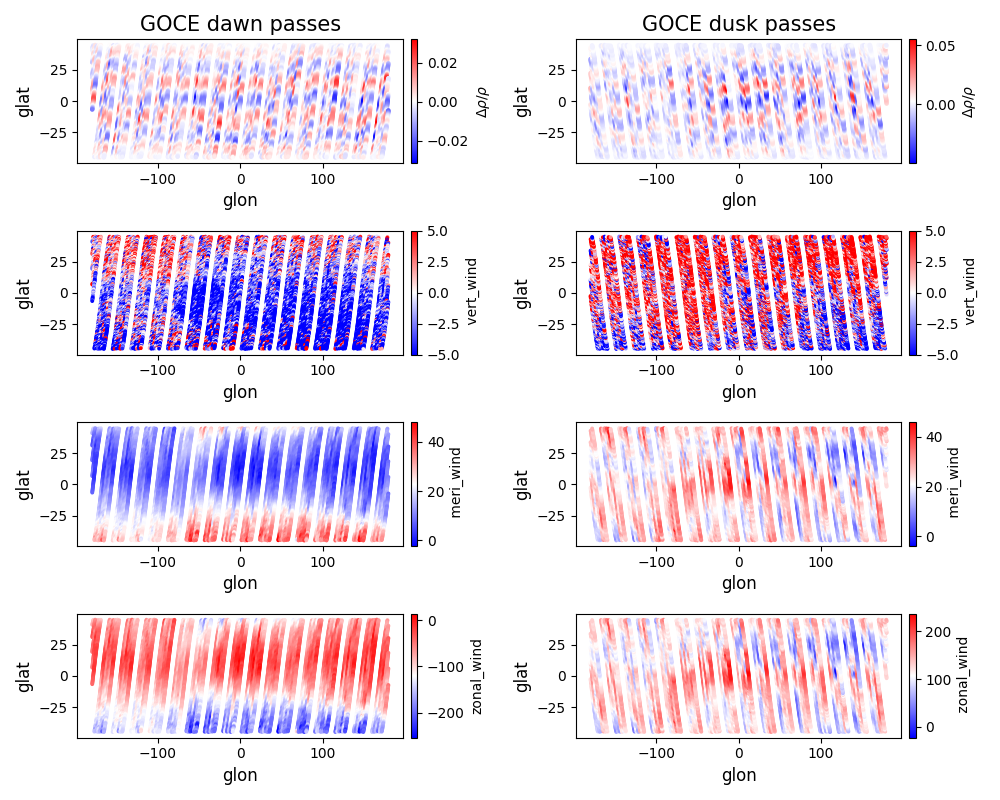

In [34]:
fig,ax = plt.subplots(4,2,figsize=[10,8],sharex=False)
p0 = ax[0,0].scatter(df_mrng.glon,df_mrng.glat,s=5,c=df_mrng.err_dens,cmap = 'bwr')
plt.colorbar(p0,ax=ax[0,0],pad=0.02,label=r'$\Delta \rho/\rho$')
p1 = ax[1,0].scatter(df_mrng.glon,df_mrng.glat,s=3,c=df_mrng.cr_wnd_u,cmap = 'bwr',vmin=-5,vmax=5)
plt.colorbar(p1,ax=ax[1,0],pad=0.02,label=r' vert_wind')
p2 = ax[2,0].scatter(df_mrng.glon,df_mrng.glat,s=3,c=df_mrng.cr_wnd_n,cmap = 'bwr')
plt.colorbar(p2,ax=ax[2,0],pad=0.02,label=r' meri_wind')
p3 = ax[3,0].scatter(df_mrng.glon,df_mrng.glat,s=3,c=df_mrng.cr_wnd_e,cmap = 'bwr')
plt.colorbar(p3,ax=ax[3,0],pad=0.02,label=r'zonal_wind')

p0 = ax[0,1].scatter(df_evng.glon,df_evng.glat,s=5,c=df_evng.err_dens,cmap = 'bwr')
plt.colorbar(p0,ax=ax[0,1],pad=0.02,label=r'$\Delta \rho/\rho$')
p1 = ax[1,1].scatter(df_evng.glon,df_evng.glat,s=3,c=df_evng.cr_wnd_u,cmap = 'bwr',vmin=-5,vmax=5)
plt.colorbar(p1,ax=ax[1,1],pad=0.02,label=r' vert_wind')
p2 = ax[2,1].scatter(df_evng.glon,df_evng.glat,s=3,c=df_evng.cr_wnd_n,cmap = 'bwr')
plt.colorbar(p2,ax=ax[2,1],pad=0.02,label=r' meri_wind')
p3 = ax[3,1].scatter(df_evng.glon,df_evng.glat,s=3,c=df_evng.cr_wnd_e,cmap = 'bwr')
plt.colorbar(p3,ax=ax[3,1],pad=0.02,label=r' zonal_wind')

for i in range(4):
    for j in range(2):
        # ax[i,j].axhline(y=0,ls='-',c='k',alpha=0.5)
        # ax[i,j].axhline(y=+15,ls='--',c='k',alpha=0.5)
        # ax[i,j].axhline(y=-15,ls='--',c='k',alpha=0.5)
        ax[i,j].set_ylabel('glat',fontsize=12);ax[i,j].set_xlabel('glon',fontsize=12);
        
ax[0,0].set_title('GOCE dawn passes',fontsize=15);
ax[0,1].set_title('GOCE dusk passes',fontsize=15);
plt.tight_layout()

## Comparison with TEC

In [36]:
# filepath = "/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/";
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
os.chdir(filepath)
filename = 'a20130112TEC.dat'
f = open(filename,'r')
tec = f.readlines()
mlat = np.arange(-40.0,40.01,0.50)
UT = range(6)
lons = [-79.0,-70.0,-60.0,-51.0]

In [37]:
df = Data.loc[dt.datetime(2013,1,12,0,0,0):dt.datetime(2013,1,12,6,0,0)]
df = df[(df['as']==0)&(df.lat>= -40)&(df.lat<= 40)]
orbit_end = find_orbits(df)
df_pass = df.loc[orbit_end[0]:orbit_end[1]]

In [38]:
fit = np.poly1d(np.polyfit(df_pass.lat,df_pass.dens_x_it,deg=7))
y_dens = np.array([fit(x) for x in df_pass.lat])
err_dens = np.convolve((df_pass.dens_x_it - y_dens)/y_dens, np.ones((N,))/N, mode='same')

In [133]:
print(df_pass.lon.mean())
print(df_pass.index[0] + (df_pass.index[-1]-df_pass.index[0])/2)

-79.30778991596641
2013-01-12 00:32:00


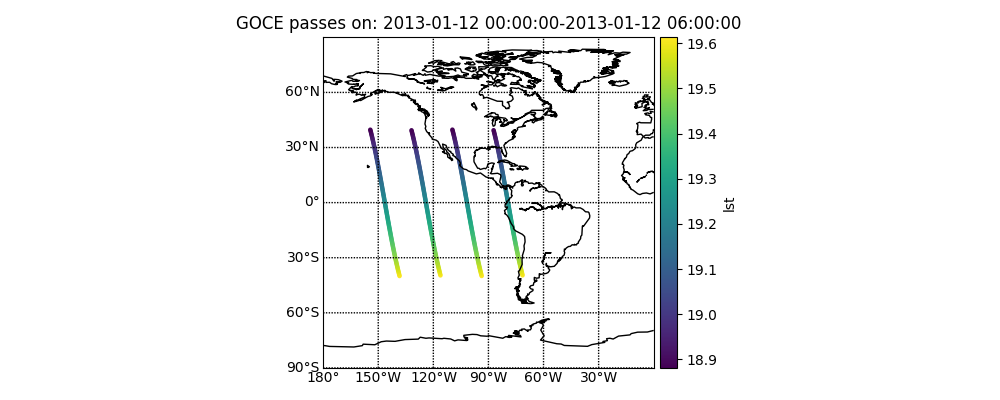

In [39]:
plt.figure(figsize=[10,4])

m= Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=0,urcrnrlat=90)
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,1])
m.drawmeridians(np.arange(-180,0,30),labels=[1,0,0,1])
m.scatter(df['lon'],df['lat'],c=df.lst,s=5)
cbar = m.colorbar(label='lst',aspect=50)
plt.title('GOCE passes on: '+ dt.datetime(2013,1,12).strftime("%Y-%m-%d %H:%M:%S") + '-' + dt.datetime(2013,1,12,6,0,0).strftime("%Y-%m-%d %H:%M:%S"))
plt.tight_layout()

In [40]:
n= 0;
res = np.zeros((len(lons),len(UT),len(mlat)))
for i,l in enumerate(lons):
    for j,u in enumerate(UT):
        n = n+1;
        for k,m in enumerate(mlat):
            n = n+1
            lin = tec[n].split()
            lin = [float(l) for l in lin]
            res[i,j,k] = lin[1]

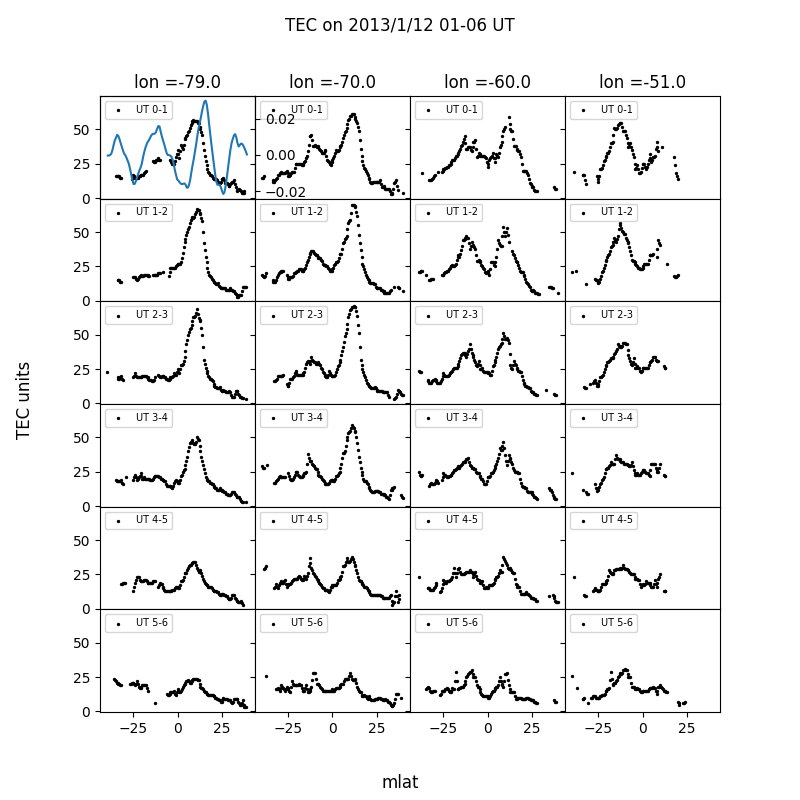

In [41]:
fig,ax = plt.subplots(len(UT),len(lons),figsize=[8,8],sharex=True,sharey=True)
for i in range(len(lons)):
    ax[0,i].set_title('lon ='+str(lons[i]))
    for j in range(len(UT)):
        y = res[i,j,:]
        # pksn, pksp, pkn, pkp = find_two_peaks(y)
#         mp = mlat[:81]
#         yneg = y[:81]
#         pksn,_ = find_peaks(yneg)
#         pkn = np.argmax(yneg[pksn])
        
#         mn = mlat[81:]
#         ypos = y[81:]
#         pksp,_ = find_peaks(ypos)
#         pkp = np.argmax(ypos[pksp])
        
        y[y == 0] = 'nan'
        
        
        ax[j,i].scatter(mlat,y,s=2,c='k',label = 'UT '+str(UT[j])+'-'+str(UT[j]+1))
        ax[j,i].legend(loc='upper left',fontsize=7)
#         ax[j,i].set_ylim([0.1,80])
#         ax[j,i].scatter(mlat[pkn],y[pkn],c='b')
#         ax[j,i].scatter(mlat[pkp],y[pkp],c='r')
plt.subplots_adjust(wspace=0, hspace=0)
fig.supylabel('TEC units')
fig.supxlabel('mlat')
fig.suptitle("TEC on 2013/1/12 01-06 UT")

ax1= ax[0,0].twinx()
ax1.plot(df_pass.lat,err_dens)

In [57]:
def find_two_peaks(arr):
    if len(arr) < 2:
        return None, None

    # Find the first peak in the first half
    for i in range(len(arr) // 2):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            first_peak = arr[i]
            first_peak_index = i
            break
    else:
        return None, None  # No peak found in the first half

    # Find the second peak in the second half
    for i in range(len(arr) // 2, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            second_peak = arr[i]
            second_peak_index = i
            break
    else:
        return None, None  # No peak found in the second half

    return first_peak, second_peak, first_peak_index, second_peak_index

# Example usage:
arr = [1, 3, 7, 1, 2, 6, 5, 4]
first_peak, second_peak, first_peak_index, second_peak_index = find_two_peaks(arr)

if first_peak is not None and second_peak is not None:
    print(f"First Peak: {first_peak} at index {first_peak_index}")
    print(f"Second Peak: {second_peak} at index {second_peak_index}")
else:
    print("No two peaks found.")


First Peak: 7 at index 2
Second Peak: 6 at index 5


In [62]:
# def find_positive_and_negative_peaks(arr):
#     positive_peak_index = None
#     positive_peak_value = None
#     negative_peak_index = None
#     negative_peak_value = None

#     for i in range(len(arr)):
#         if arr[i] > 0:
#             positive_peak_index = i
#             positive_peak_value = arr[i]
#             break

#     for i in range(len(arr)):
#         if arr[i] < 0:
#             negative_peak_index = i
#             negative_peak_value = arr[i]
#             break

#     return {
#         'positive_peak_index': positive_peak_index,
#         'positive_peak_value': positive_peak_value,
#         'negative_peak_index': negative_peak_index,
#         'negative_peak_value': negative_peak_value
#     }

# # Example usage:
# data = [1, 2, 3, -2, -1, 4, -3, 5]
# peaks = find_positive_and_negative_peaks(y)

# print("Positive Peak Index:", peaks['positive_peak_index'])
# print("Positive Peak Value:", peaks['positive_peak_value'])
# print("Negative Peak Index:", peaks['negative_peak_index'])
# print("Negative Peak Value:", peaks['negative_peak_value'])


In [ ]:
plt.figure()


In [ ]:
# m= Basemap(llcrnrlon=-180,llcrnrlat=-90, urcrnrlon=0,urcrnrlat=90);
# m.drawcoastlines();
# m.drawcountries
# m.drawparallels(np.arange(-90,90,30),labels=[1,0,1,0]);
# m.drawmeridians(np.arange(-180,0,30),labels=[1,0,1,0]);

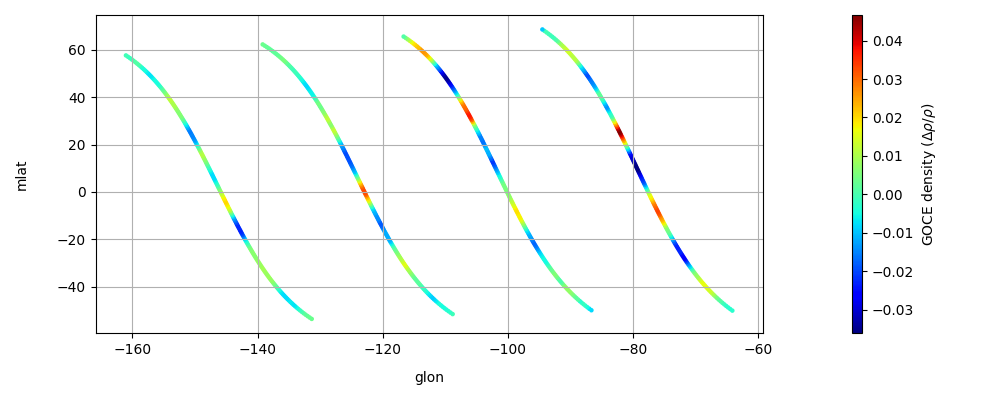

In [13]:
plt.figure(figsize=[10,4])
plt.xlabel('glon',labelpad=10); plt.ylabel('mlat',labelpad=20)
plt.scatter(df_evng['glon'],df_evng['mlat'],s=5,c=df_evng['err_dens'],cmap='jet')
plt.colorbar(label = r'GOCE density ($\Delta \rho/\rho$)',aspect=30, pad=0.1)
plt.tight_layout()
plt.grid()
# for i,l in enumerate(lons)
# m.scatter()

In [48]:
df_mrng=pd.DataFrame(); df_evng=pd.DataFrame();
for i in range(days):
    t0 = start + dt.timedelta(days=i-1)
    t1 = start + dt.timedelta(days=i)
    df = Data.loc[t0:t1] ## all the passes in a day
    
    df_dawn = df[df['as']==1.0];  ## all the dawn passes in a day
    if len(df_dawn)> 0:
        gaps = np.where(np.array([(df_dawn.index[m+1]-df_dawn.index[m])/dt.timedelta(seconds=1) for m in range(len(df_dawn)-1)])>500)[0]
        gaps = np.insert(gaps,[0,len(gaps)],[0,len(df_dawn)-1])
        orbit_end = df_dawn.index[gaps]
        for oe in range(len(orbit_end)-1):
            df_pass = df_dawn[(df_dawn.index>=orbit_end[oe])& (df_dawn.index <= orbit_end[oe+1])&(df_dawn.mlat>=-45)&(df_dawn.mlat<=45)]
            if len(df_pass) > 0:
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.dens_x_it,deg=7))
                y_dens = np.array([fit(x) for x in df_pass.mlat])
                err_dens = uniform_filter1d((df_pass.dens_x_it - y_dens),6)/y_dens
                
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.cr_wnd_u,deg=7))
                y_cr_wnd_u = np.array([fit(x) for x in df_pass.mlat])
                err_cr_wnd_u = uniform_filter1d((df_pass.cr_wnd_u - y_cr_wnd_u),6)
                
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.cr_wnd_n,deg=7))
                y_cr_wnd_n = np.array([fit(x) for x in df_pass.mlat])
                err_cr_wnd_n = uniform_filter1d((df_pass.cr_wnd_n - y_cr_wnd_n),6)
                
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.cr_wnd_e,deg=7))
                y_cr_wnd_e = np.array([fit(x) for x in df_pass.mlat])
                err_cr_wnd_e = uniform_filter1d((df_pass.cr_wnd_e - y_cr_wnd_e),6)
                
                df_mrng = pd.concat([df_mrng,pd.DataFrame({'glat':df_pass['lat'],
                                                           'mlat':df_pass['mlat'],
                                                          'glon':df_pass['lon'],
                                                           'mlt':df_pass['mlt'],
                                                          'alt':df_pass['alt'],
                                                           'lst':df_pass['lst'],
                                                         'rho':df_pass['dens_x_it'],
                                                         'err_dens':err_dens,
                                                          'cr_wnd_u':df_pass['cr_wnd_u'],
                                                          'err_cr_wnd_u':err_cr_wnd_u,
                                                          'cr_wnd_n':df_pass['cr_wnd_n'],
                                                          'err_cr_wnd_n':err_cr_wnd_n,
                                                        'cr_wnd_e':df_pass['cr_wnd_e'],
                                                          'err_cr_wnd_e':err_cr_wnd_e})])
    
    df_dusk = df[df['as']==0.0];  ## all the dusk passes in a day
    if len(df_dusk)> 0:
        gaps = np.where(np.array([(df_dusk.index[m+1]-df_dusk.index[m])/dt.timedelta(seconds=1) for m in range(len(df_dusk)-1)])>500)[0]
        gaps = np.insert(gaps,[0,len(gaps)],[0,len(df_dusk)-1])
        orbit_end = df_dusk.index[gaps]
        for oe in range(len(orbit_end)-1):
            df_pass = df_dusk[(df_dusk.index>=orbit_end[oe])& (df_dusk.index <= orbit_end[oe+1])&(df_dusk.mlat>=-45)&(df_dusk.mlat<=45)]
            if len(df_pass) > 0:
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.dens_x_it,deg=7))
                y_dens = np.array([fit(x) for x in df_pass.mlat])
                err_dens = uniform_filter1d((df_pass.dens_x_it - y_dens),6)/y_dens
                
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.cr_wnd_u,deg=7))
                y_cr_wnd_u = np.array([fit(x) for x in df_pass.mlat])
                err_cr_wnd_u = uniform_filter1d((df_pass.cr_wnd_u - y_cr_wnd_u),6)
                
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.cr_wnd_n,deg=7))
                y_cr_wnd_n = np.array([fit(x) for x in df_pass.mlat])
                err_cr_wnd_n = uniform_filter1d((df_pass.cr_wnd_n - y_cr_wnd_n),6)
                
                fit = np.poly1d(np.polyfit(df_pass.mlat,df_pass.cr_wnd_e,deg=7))
                y_cr_wnd_e = np.array([fit(x) for x in df_pass.mlat])
                err_cr_wnd_e = uniform_filter1d((df_pass.cr_wnd_e - y_cr_wnd_e),6)
                
                df_evng = pd.concat([df_evng,pd.DataFrame({'glat':df_pass['lat'],
                                                           'mlat':df_pass['mlat'],
                                                           'glon':df_pass['lon'],
                                                           'mlt':df_pass['mlt'],
                                                           'alt':df_pass['alt'],
                                                           'lst':df_pass['lst'],
                                                         'rho':df_pass['dens_x_it'],
                                                         'err_dens':err_dens,
                                                          'cr_wnd_u':df_pass['cr_wnd_u'],
                                                          'err_cr_wnd_u':err_cr_wnd_u,
                                                          'cr_wnd_n':df_pass['cr_wnd_n'],
                                                          'err_cr_wnd_n':err_cr_wnd_n,
                                                        'cr_wnd_e':df_pass['cr_wnd_e'],
                                                          'err_cr_wnd_e':err_cr_wnd_e})])

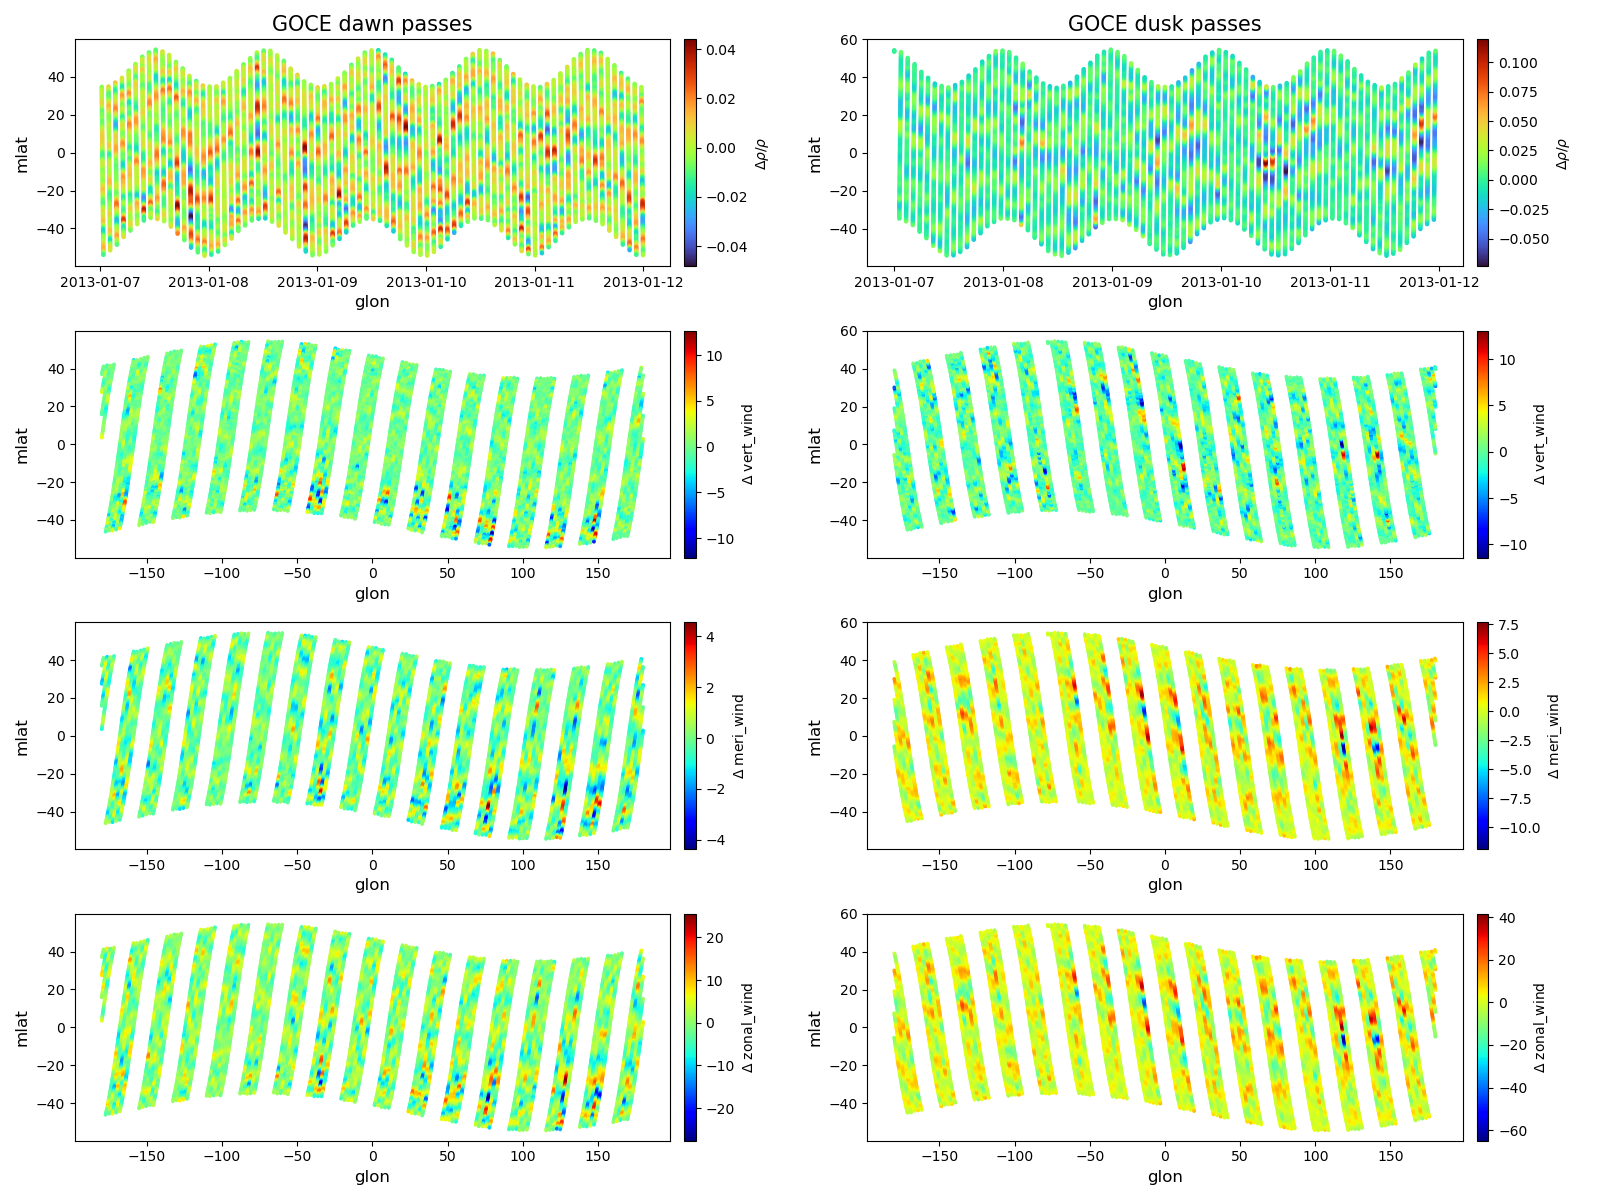

In [64]:
fig,ax = plt.subplots(4,2,figsize=[16,12],sharex=False)
p0 = ax[0,0].scatter(df_mrng.index,df_mrng.mlat,s=5,c=df_mrng.err_dens,cmap = 'turbo')
plt.colorbar(p0,ax=ax[0,0],pad=0.02,label=r'$\Delta \rho/\rho$')

p1 = ax[1,0].scatter(df_mrng.glon,df_mrng.mlat,s=3,c=df_mrng.err_cr_wnd_u,cmap = 'jet')
plt.colorbar(p1,ax=ax[1,0],pad=0.02,label=r'$\Delta$ vert_wind')
p2 = ax[2,0].scatter(df_mrng.glon,df_mrng.mlat,s=3,c=df_mrng.err_cr_wnd_n,cmap = 'jet')
plt.colorbar(p2,ax=ax[2,0],pad=0.02,label=r'$\Delta$ meri_wind')
p3 = ax[3,0].scatter(df_mrng.glon,df_mrng.mlat,s=3,c=df_mrng.err_cr_wnd_e,cmap = 'jet')
plt.colorbar(p3,ax=ax[3,0],pad=0.02,label=r'$\Delta$ zonal_wind')

p0 = ax[0,1].scatter(df_evng.index,df_evng.mlat,s=5,c=df_evng.err_dens,cmap = 'turbo')
plt.colorbar(p0,ax=ax[0,1],pad=0.02,label=r'$\Delta \rho/\rho$')
p1 = ax[1,1].scatter(df_evng.glon,df_evng.mlat,s=3,c=df_evng.err_cr_wnd_u,cmap = 'jet')
plt.colorbar(p1,ax=ax[1,1],pad=0.02,label=r'$\Delta$ vert_wind')
p2 = ax[2,1].scatter(df_evng.glon,df_evng.mlat,s=3,c=df_evng.err_cr_wnd_n,cmap = 'jet')
plt.colorbar(p2,ax=ax[2,1],pad=0.02,label=r'$\Delta$ meri_wind')
p3 = ax[3,1].scatter(df_evng.glon,df_evng.mlat,s=3,c=df_evng.err_cr_wnd_e,cmap = 'jet')
plt.colorbar(p3,ax=ax[3,1],pad=0.02,label=r'$\Delta$ zonal_wind')

for i in range(4):
    for j in range(2):
        # ax[i,j].axhline(y=0,ls='-',c='k',alpha=0.5)
        # ax[i,j].axhline(y=+15,ls='--',c='k',alpha=0.5)
        # ax[i,j].axhline(y=-15,ls='--',c='k',alpha=0.5)
        ax[i,j].set_ylabel('mlat',fontsize=12);ax[i,j].set_xlabel('glon',fontsize=12);
        
ax[0,0].set_title('GOCE dawn passes',fontsize=15);
ax[0,1].set_title('GOCE dusk passes',fontsize=15);
plt.tight_layout()

In [81]:
plt.close('all')

In [6]:
## find days with Dst < 20
quiet_days = [];
for i in range(365):
    df = SW_Data_hr.loc[start+dt.timedelta(days=i):start+dt.timedelta(days=i+1)]['Dst']
    if all(np.abs(x)<20 for x in df):
        t = start+dt.timedelta(days=i)
        quiet_days.append(t.date())

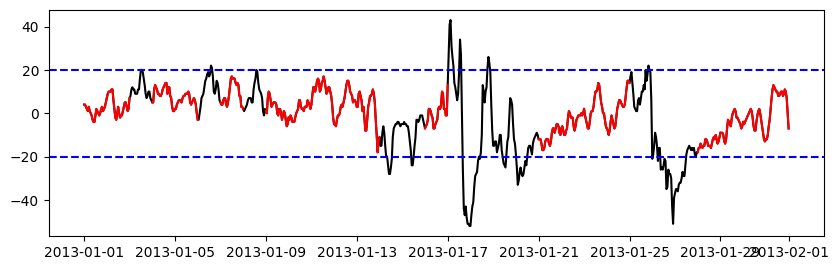

In [7]:
plt.figure(figsize=[10,3],dpi=100)
plt.plot(SW_Data_hr['Dst'],c='k')
for q in quiet_days:
    plt.plot(SW_Data_hr['Dst'].loc[q:q+dt.timedelta(days=1)],c='r')
plt.axhline(y = -20,ls='--',c='b')
plt.axhline(y = 20,ls='--',c='b')

## I dont't know why I am making these plots. No one will see this.